# pip & import

In [1]:
!pip install scikit-surprise

In [2]:
!pip install category_encoders

In [3]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import category_encoders as ce
from surprise import SVD
from surprise import Dataset
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise.dataset import DatasetAutoFolds
import os
import matplotlib.pyplot as plt
import seaborn as sns

# 데이터 가공 및 변환

In [5]:
apply_train_df = pd.read_csv('apply_train.csv')
resume_train_df = pd.read_csv('resume.csv')
certificate_df = pd.read_csv('resume_certificate.csv')
education_train_df = pd.read_csv('resume_education.csv')
language_train_df = pd.read_csv('resume_language.csv')
company_train_df = pd.read_csv('company.csv')
recruitment_train_df = pd.read_csv('recruitment.csv')

In [6]:
count_by_recruitment_seq = apply_train_df.groupby('recruitment_seq')['resume_seq'].count()
count_by_recruitment_seq = count_by_recruitment_seq.reset_index()
count_by_recruitment_seq.columns = ['recruitment_seq', 'rating']

# 업데이트된 DataFrame을 확인합니다.
count_by_recruitment_seq

,recruitment_seq,rating
0,R00001,11
1,R00002,6
2,R00003,7
3,R00004,15
4,R00005,5
...,...,...
6690,R06691,6
6691,R06692,11
6692,R06693,4
6693,R06694,7


In [7]:
total_user = resume_train_df.sort_values(by='resume_seq')
certificate_df = certificate_df.dropna(subset=['certificate_contents'])
tmp = certificate_df.groupby('resume_seq')['certificate_contents'].apply(';'.join).reset_index()
total_user = pd.merge(total_user, tmp, on='resume_seq', how='left')
total_user = pd.merge(total_user, education_train_df, on='resume_seq', how='left')
total_user = pd.merge(total_user, apply_train_df, on='resume_seq', how='left')

In [8]:
total_item = recruitment_train_df
total_item = pd.merge(total_item, company_train_df, on='recruitment_seq', how='left')
total_item = pd.merge(total_item, count_by_recruitment_seq, on='recruitment_seq', how='left')
total_item

,recruitment_seq,address_seq1,address_seq2,address_seq3,career_end,career_start,check_box_keyword,education,major_task,qualifications,text_keyword,company_type_seq,supply_kind,employee,rating
0,R02264,3.0,NaN,NaN,0,0,2507;2707;2810,4,8,1,NaN,5.0,402.0,800.0,14
1,R06317,3.0,NaN,NaN,0,0,2204;2205;2707,3,2,1,NaN,NaN,NaN,NaN,7
2,R04017,3.0,NaN,NaN,0,0,2101;2108;2201;2707,3,2,1,NaN,NaN,NaN,NaN,3
3,R02865,3.0,NaN,NaN,0,0,2201;2204;2205;2707,2,2,1,NaN,NaN,NaN,NaN,5
4,R04890,3.0,NaN,NaN,0,0,2201;2204;2205;2707,2,2,2,NaN,NaN,NaN,NaN,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6690,R03678,3.0,NaN,NaN,0,0,2101;2108;2201;2204;2205;2707,3,2,1,NaN,NaN,NaN,NaN,34
6691,R04593,3.0,NaN,NaN,0,0,2201;2204;2205;2707,4,2,1,NaN,NaN,NaN,NaN,12
6692,R03252,3.0,NaN,NaN,0,0,2109,3,2,1,NaN,4.0,402.0,525.0,7
6693,R05130,3.0,NaN,NaN,0,0,2201;2204;2205;2707,2,2,2,NaN,2.0,402.0,40.0,6


In [9]:
total = pd.merge(total_user, total_item, on='recruitment_seq', how='left')
total

,resume_seq,reg_date,updated_date,degree,graduate_date,hope_salary,last_salary,text_keyword_x,job_code_seq1,job_code_seq2,...,career_start,check_box_keyword,education,major_task,qualifications,text_keyword_y,company_type_seq,supply_kind,employee,rating
0,U00001,2019-12-27,2020-02-01,4,2009,1500.0,1500.0,디자이너,재료·화학·섬유·의복,NaN,...,0,2507,4,7,1,NaN,NaN,NaN,NaN,12
1,U00001,2019-12-27,2020-02-01,4,2009,1500.0,1500.0,디자이너,재료·화학·섬유·의복,NaN,...,0,2507;2707,3,2,2,NaN,NaN,NaN,NaN,6
2,U00001,2019-12-27,2020-02-01,4,2009,1500.0,1500.0,디자이너,재료·화학·섬유·의복,NaN,...,0,2507,4,7,1,NaN,NaN,NaN,NaN,8
3,U00001,2019-12-27,2020-02-01,4,2009,1500.0,1500.0,디자이너,재료·화학·섬유·의복,NaN,...,0,2507;2707;2799,3,2,2,NaN,NaN,NaN,NaN,16
4,U00002,2020-04-24,2020-04-29,4,2005,0.0,0.0,디자이너,재료·화학·섬유·의복,NaN,...,0,2707;2507,4,2,1,의류;의상;여성복,NaN,NaN,NaN,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57941,U08481,2020-07-09,2020-11-23,4,2015,0.0,2700.0,상품기획;머천다이저;기획MD,재료·화학·섬유·의복,NaN,...,0,2101;2108;2201;2707,3,2,2,NaN,2.0,100.0,200.0,6
57942,U08481,2020-07-09,2020-11-23,4,2015,0.0,2700.0,상품기획;머천다이저;기획MD,재료·화학·섬유·의복,NaN,...,0,2101;2108;2201;2707,2,2,2,NaN,NaN,NaN,NaN,7
57943,U08482,2020-11-29,2020-11-29,4,0,0.0,0.0,상품기획;영업MD;머천다이저;기획MD;마케팅;PR,재료·화학·섬유·의복,NaN,...,0,2101;2108;2201;2707,3,2,2,NaN,NaN,NaN,NaN,13
57944,U08482,2020-11-29,2020-11-29,4,0,0.0,0.0,상품기획;영업MD;머천다이저;기획MD;마케팅;PR,재료·화학·섬유·의복,NaN,...,0,2101;2108;2109;2201;2203;2204;2205;2302;2507;2707,2,2,2,NaN,NaN,NaN,NaN,19


In [10]:
total.columns

Index(['resume_seq', 'reg_date', 'updated_date', 'degree', 'graduate_date',
       'hope_salary', 'last_salary', 'text_keyword_x', 'job_code_seq1',
       'job_code_seq2', 'job_code_seq3', 'career_month', 'career_job_code',
       'certificate_contents', 'hischool_type_seq', 'hischool_special_type',
       'hischool_nation', 'hischool_gender', 'hischool_location_seq',
       'univ_type_seq1', 'univ_type_seq2', 'univ_transfer', 'univ_location',
       'univ_major', 'univ_sub_major', 'univ_major_type', 'univ_score',
       'recruitment_seq', 'address_seq1', 'address_seq2', 'address_seq3',
       'career_end', 'career_start', 'check_box_keyword', 'education',
       'major_task', 'qualifications', 'text_keyword_y', 'company_type_seq',
       'supply_kind', 'employee', 'rating'],
      dtype='object')

In [11]:
apply_matrix = apply_train_df.groupby(['resume_seq', 'recruitment_seq']).size().unstack(fill_value=0)

In [12]:
correlation = total[['address_seq1', 'hischool_location_seq']].corr()
correlation

,address_seq1,hischool_location_seq
address_seq1,1.000000,-0.007927
hischool_location_seq,-0.007927,1.000000


In [13]:
correlation = total[['address_seq1', 'univ_location']].corr()
correlation

,address_seq1,univ_location
address_seq1,1.000000,-0.002498
univ_location,-0.002498,1.000000


<Axes: ylabel='Frequency'>

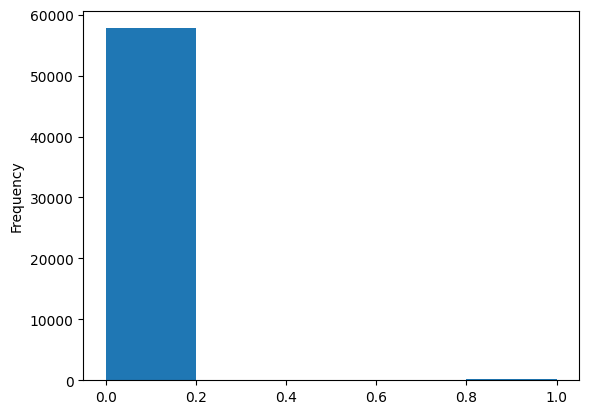

In [14]:
total['univ_transfer'].plot.hist(bins=5)

<Axes: ylabel='Frequency'>

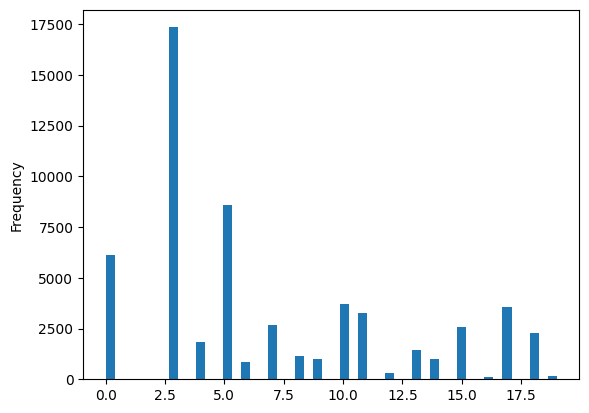

In [15]:
total['univ_location'].plot.hist(bins=50)

<Axes: ylabel='last_salary'>

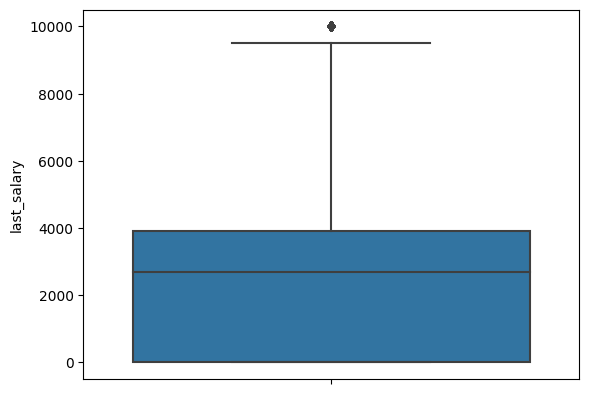

In [16]:
sns.boxplot(y=total['last_salary'], data=total)

<Axes: ylabel='hope_salary'>

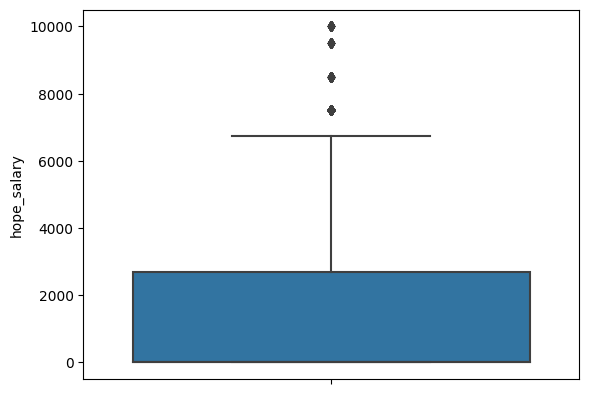

In [17]:
sns.boxplot(y=total['hope_salary'], data=total)

<Axes: xlabel='address_seq1', ylabel='hischool_location_seq'>

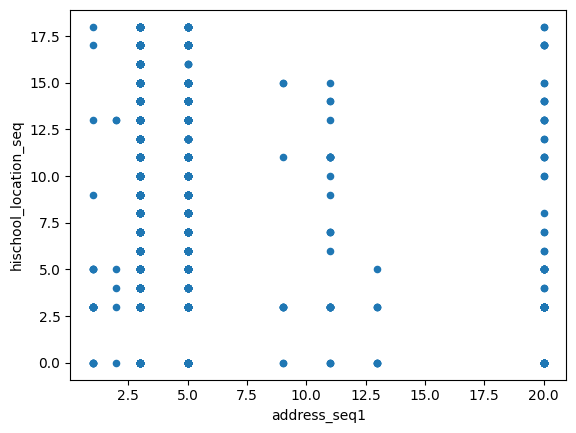

In [18]:
total.plot(kind='scatter', x='address_seq1', y='hischool_location_seq')

<Axes: xlabel='address_seq1', ylabel='univ_location'>

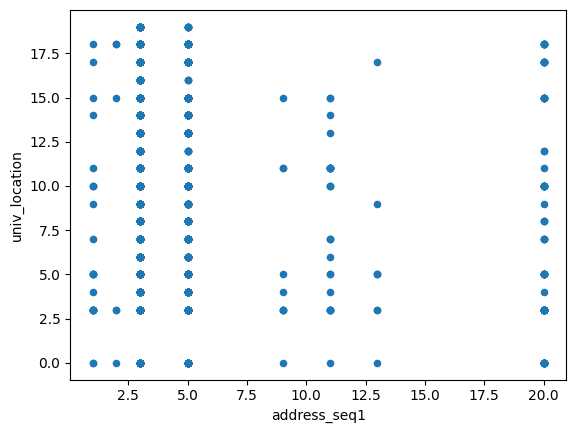

In [19]:
total.plot(kind='scatter', x='address_seq1', y='univ_location')

<Axes: >

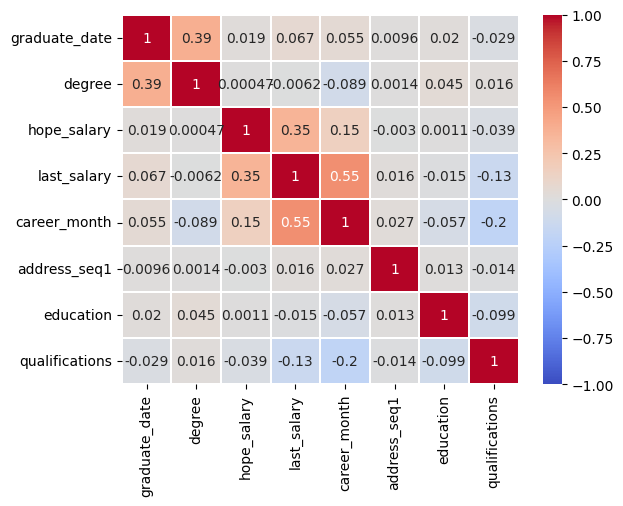

In [20]:
total_tmp = total[['graduate_date','degree','hope_salary','last_salary', 'career_month', 'address_seq1', 'education', 'qualifications']]
sns.heatmap(total_tmp.corr(),vmin=-1,vmax=1,annot=True,linewidths=0.2,cmap='coolwarm')

<Axes: >

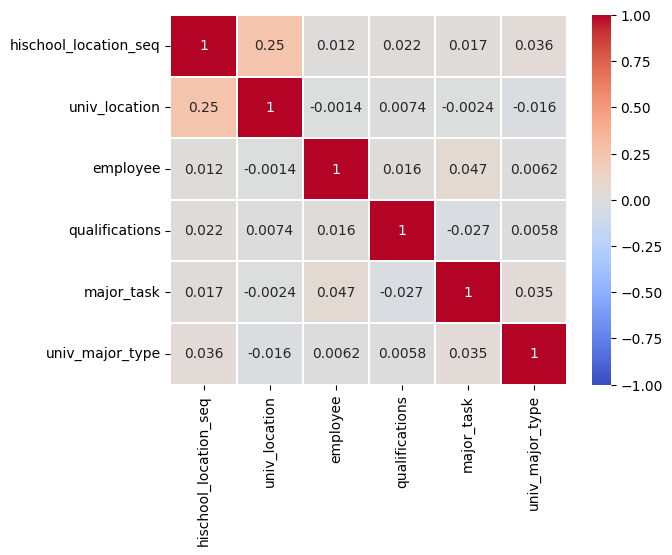

In [21]:
total_tmp = total[['hischool_location_seq','univ_location','employee','qualifications', 'major_task', 'univ_major_type']]
sns.heatmap(total_tmp.corr(),vmin=-1,vmax=1,annot=True,linewidths=0.2,cmap='coolwarm')

In [22]:
total_tmp = total[['resume_seq','univ_major_type','company_type_seq', 'major_task']]
total_tmp

,resume_seq,univ_major_type,company_type_seq,major_task
0,U00001,9,NaN,7
1,U00001,9,NaN,2
2,U00001,9,NaN,7
3,U00001,9,NaN,2
4,U00002,8,NaN,2
...,...,...,...,...
57941,U08481,9,2.0,2
57942,U08481,9,NaN,2
57943,U08482,9,NaN,2
57944,U08482,9,NaN,2


In [23]:
total['major_task'].value_counts()

2     54954
8      1906
7       797
1       248
9        21
10       15
6         5
Name: major_task, dtype: int64

In [ ]:
total['univ_major_type'].value_counts()

9     20616
3      7952
4      6068
19     4546
5      4339
0      3173
8      3119
10     2003
20      985
18      767
2       711
7       706
13      493
6       435
14      392
15      376
17      323
23      292
11      218
16      143
12      117
22      101
21       71
Name: univ_major_type, dtype: int64

In [24]:
total['univ_location'].value_counts()

3     17349
5      8584
0      6133
10     3693
17     3574
11     3254
7      2672
15     2553
18     2274
4      1853
13     1465
8      1146
9      1016
14      990
6       843
12      296
19      150
16      101
Name: univ_location, dtype: int64

In [25]:
total['address_seq1'].value_counts()

3.0     56270
5.0      1475
20.0      115
11.0       29
1.0        27
9.0        10
13.0        8
2.0         6
Name: address_seq1, dtype: int64

In [26]:
total[total['address_seq1'] == total['univ_location']].count()

resume_seq               17049
reg_date                 17049
updated_date             17049
degree                   17049
graduate_date            17049
hope_salary              17049
last_salary              17049
text_keyword_x           16633
job_code_seq1            17049
job_code_seq2              849
job_code_seq3              275
career_month             17049
career_job_code          16036
certificate_contents     11709
hischool_type_seq        17049
hischool_special_type    17049
hischool_nation          17049
hischool_gender          17049
hischool_location_seq    17049
univ_type_seq1           17049
univ_type_seq2           17049
univ_transfer            17049
univ_location            17049
univ_major                3187
univ_sub_major             810
univ_major_type          17049
univ_score               17049
recruitment_seq          17049
address_seq1             17049
address_seq2               236
address_seq3                21
career_end               17049
career_s

In [27]:
total[(total['address_seq1'] - total['univ_location']<7) & (total['address_seq1'] - total['univ_location']>-7)].count()

resume_seq               39707
reg_date                 39707
updated_date             39707
degree                   39707
graduate_date            39707
hope_salary              39707
last_salary              39707
text_keyword_x           38841
job_code_seq1            39707
job_code_seq2             1975
job_code_seq3              733
career_month             39707
career_job_code          37473
certificate_contents     28316
hischool_type_seq        39707
hischool_special_type    39707
hischool_nation          39707
hischool_gender          39707
hischool_location_seq    39707
univ_type_seq1           39707
univ_type_seq2           39707
univ_transfer            39707
univ_location            39707
univ_major                9310
univ_sub_major            1951
univ_major_type          39707
univ_score               39707
recruitment_seq          39707
address_seq1             39707
address_seq2               553
address_seq3                48
career_end               39707
career_s

In [28]:
total[(total['address_seq1'] - total['hischool_location_seq']<=7) & (total['address_seq1'] - total['hischool_location_seq']>=-7)].count()

resume_seq               45982
reg_date                 45982
updated_date             45982
degree                   45982
graduate_date            45982
hope_salary              45982
last_salary              45982
text_keyword_x           44933
job_code_seq1            45982
job_code_seq2             2544
job_code_seq3              981
career_month             45982
career_job_code          43298
certificate_contents     33154
hischool_type_seq        45982
hischool_special_type    45982
hischool_nation          45982
hischool_gender          45982
hischool_location_seq    45982
univ_type_seq1           45982
univ_type_seq2           45982
univ_transfer            45982
univ_location            45982
univ_major               10602
univ_sub_major            2123
univ_major_type          45982
univ_score               45982
recruitment_seq          45982
address_seq1             45982
address_seq2               686
address_seq3                63
career_end               45982
career_s

In [29]:
total['degree'].value_counts()

4    50468
3     3537
5     2202
2     1688
6       51
Name: degree, dtype: int64

In [30]:
resume_train_df['degree'].value_counts()

4    7453
3     463
5     349
2     211
6       6
Name: degree, dtype: int64

In [31]:
recruitment_train_df['education'].value_counts()

3    2862
4    2188
2    1644
6       1
Name: education, dtype: int64

In [32]:
total[(total['education'] - total['degree']==-2)& (total['degree']==5)].count()

resume_seq               844
reg_date                 844
updated_date             844
degree                   844
graduate_date            844
hope_salary              844
last_salary              844
text_keyword_x           837
job_code_seq1            844
job_code_seq2             42
job_code_seq3             35
career_month             844
career_job_code          811
certificate_contents     631
hischool_type_seq        844
hischool_special_type    844
hischool_nation          844
hischool_gender          844
hischool_location_seq    844
univ_type_seq1           844
univ_type_seq2           844
univ_transfer            844
univ_location            844
univ_major               197
univ_sub_major            24
univ_major_type          844
univ_score               844
recruitment_seq          844
address_seq1             844
address_seq2              13
address_seq3               0
career_end               844
career_start             844
check_box_keyword        844
education     

# 회사 최소 조건

In [33]:
resume_c = resume_train_df.copy()
recruitment_c = recruitment_train_df.copy()

In [34]:
# 'resume_seq' 열을 기준으로 정렬
resume_c = resume_c.sort_values(by='resume_seq')
# 인덱스를 순차적으로 변경
resume_c['resume_seq'] = [f'U{i:05}' for i in range(1, len(resume_c) + 1)]
resume_c = resume_c.set_index('resume_seq')

# 'resume_seq' 열을 기준으로 정렬
recruitment_c = recruitment_c.sort_values(by='recruitment_seq')
# 인덱스를 순차적으로 변경
recruitment_c['recruitment_seq'] = [f'R{i:05}' for i in range(1, len(recruitment_c) + 1)]
recruitment_c = recruitment_c.set_index('recruitment_seq')

In [35]:
resume_c = resume_c[['degree']]
recruitment_c = recruitment_c[['education']]

In [36]:
apply_item_matrix_new = []
count = 0
# 초등학생들 ^^
tem_6 = [] # U05886이 6학년
tem_5 = [] # U08422이 5학년
tem_4 = [] # U04600이 4학년
tem_3 = [] # U03400이 3학년
tem_2 = [] # U04220이 2학년

for recruitment_seq in range(len(recruitment_c)): #
  if resume_c.loc['U05886']['degree'] < recruitment_c.iloc[recruitment_seq]['education']:
        a = False
  else:
        a = True
  tem_6.append(a)

for recruitment_seq in range(len(recruitment_c)):
  if resume_c.loc['U08422']['degree'] < recruitment_c.iloc[recruitment_seq]['education']:
        a = False
  else:
        a = True
  tem_5.append(a)

for recruitment_seq in range(len(recruitment_c)):
  if resume_c.loc['U04600']['degree'] < recruitment_c.iloc[recruitment_seq]['education']:
        a = False
  else:
        a = True
  tem_4.append(a)

for recruitment_seq in range(len(recruitment_c)):
  if resume_c.loc['U03400']['degree'] < recruitment_c.iloc[recruitment_seq]['education']:
        a = False
  else:
        a = True
  tem_3.append(a)

for recruitment_seq in range(len(recruitment_c)):
  if resume_c.loc['U04220']['degree'] < recruitment_c.iloc[recruitment_seq]['education']:
        a = False
  else:
        a = True
  tem_2.append(a)

# apply_item_matrix의 인덱스(=resume_seq)와 컬럼(=recruitment_seq)을 뽑아냄
for resume_seq in range(len(resume_c)):
    if resume_c.iloc[resume_seq]['degree'] == 6:
      apply_item_matrix_new.append(tem_6)
    elif resume_c.iloc[resume_seq]['degree'] == 5:
      apply_item_matrix_new.append(tem_5)
    elif resume_c.iloc[resume_seq]['degree'] == 4:
      apply_item_matrix_new.append(tem_4)
    elif resume_c.iloc[resume_seq]['degree'] == 3:
      apply_item_matrix_new.append(tem_3)
    else:
      apply_item_matrix_new.append(tem_2)

# 새로운 DataFrame 생성
apply_item_matrix_new = pd.DataFrame(apply_item_matrix_new, index=apply_matrix.index, columns=apply_matrix.columns)
apply_item_matrix_new

recruitment_seq,R00001,R00002,R00003,R00004,R00005,R00006,R00007,R00008,R00009,R00010,...,R06686,R06687,R06688,R06689,R06690,R06691,R06692,R06693,R06694,R06695
resume_seq,,,,,,,,,,,,,,,,,,,,,
U00001,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
U00002,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
U00003,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
U00004,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
U00005,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
U08478,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
U08479,True,True,True,True,True,False,True,True,True,True,...,True,True,True,True,True,True,True,False,False,True
U08480,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True


# 함수 정의

In [ ]:
def recall5(answer_df, submission_df):

    primary_col = answer_df.columns[0]
    secondary_col = answer_df.columns[1]

    # submission의 예측이 각각 5개인지 확인
    prediction_counts = submission_df.groupby(primary_col).size()
    if not all(prediction_counts == 5):
        raise ValueError(f"Each {primary_col} should have exactly 5 {secondary_col} predictions.")


    # submission의 예측된 값들에 null값이 있는지 확인
    if submission_df[secondary_col].isnull().any():
        raise ValueError(f"Predicted {secondary_col} contains NULL values.")

    # 예측값에 중복이 있는지 확인
    duplicated_preds = submission_df.groupby(primary_col).apply(lambda x: x[secondary_col].duplicated().any())
    if duplicated_preds.any():
        raise ValueError(f"Predicted {secondary_col} contains duplicates for some {primary_col}.")


    # Filter the submission dataframe based on the primary_col present in the answer dataframe
    # primary_col 즉 resume_seq가 양측에 있는지 확인 후 남김
    submission_df = submission_df[submission_df[primary_col].isin(answer_df[primary_col])]

    # For each primary_col, get the top 5 predicted secondary_col values
    #
    top_5_preds = submission_df.groupby(primary_col).apply(lambda x: x[secondary_col].head(5).tolist()).to_dict()

    # Convert the answer_df to a dictionary for easier lookup
    true_dict = answer_df.groupby(primary_col).apply(lambda x: x[secondary_col].tolist()).to_dict()


    individual_recalls = []
    for key, val in true_dict.items():
        if key in top_5_preds:
            correct_matches = len(set(true_dict[key]) & set(top_5_preds[key]))
            individual_recall = correct_matches / min(len(val), 5) # 공정한 평가를 가능하게 위하여 분모(k)를 'min(len(val), 5)' 로 설정함
            individual_recalls.append(individual_recall)


    recall = np.mean(individual_recalls)
    return recall

In [ ]:
def minimum_condition(resume, company):
  if(resume['degree'] < company['education']):
    return False
  else:
    return True
   # if(resume['career_month']>company['career_end'] or resume['career_month']<company['career_start']): 다 0임
     # return False
   # else:


In [ ]:
def check_salary(salary):
  if salary>3000:
    return 3
  elif salary>2000:
    return 2
  elif salary>1000:
    return 1
  else:
    return 0

In [ ]:
def check_career_month(career_month):
  if career_month>120:
    return 3
  elif career_month>60:
    return 2
  elif career_month>0:
    return 1
  else:
    return 0

In [ ]:
def check_univ_score(univ_score):
  if univ_score>=90:
    return 90
  elif univ_score>=80:
    return 80
  elif univ_score>=70:
    return 70
  elif univ_score>=60:
    return 60
  elif univ_score>=50:
    return 50
  elif univ_score>=40:
    return 40
  elif univ_score>=30:
    return 30
  elif univ_score>=20:
    return 20
  elif univ_score>=10:
    return 10
  else:
    return 0

# apply_matrix

In [ ]:
#학습, 검증 분리
train, test = [], []
apply_train_groupby = apply_train_df.groupby('resume_seq')['recruitment_seq'].apply(list)
for uid, iids in zip(apply_train_groupby.index.tolist(), apply_train_groupby.values.tolist()):
    for iid in iids[:-1]:
        train.append([uid,iid])
    test.append([uid, iids[-1]])

In [ ]:
apply_train = pd.DataFrame(train, columns=['resume_seq', 'recruitment_seq'])
apply_test = pd.DataFrame(test, columns=['resume_seq', 'recruitment_seq'])
apply_pred = apply_train_df.copy()

In [ ]:
# 사용자-아이템 행렬 생성: 구직자가 해당 채용 공고에 지원했으면 1, 아니면 0으로 설정
apply_train_item_matrix = apply_train.groupby(['resume_seq', 'recruitment_seq']).size().unstack(fill_value=0)
apply_train_similarity = cosine_similarity(apply_train_item_matrix) # 사용자 간의 유사성 계산

apply_pred_item_matrix = apply_pred.groupby(['resume_seq', 'recruitment_seq']).size().unstack(fill_value=0)
apply_pred_similarity = cosine_similarity(apply_pred_item_matrix) # 사용자 간의 유사성 계산

In [ ]:
apply_train_matrix = pd.DataFrame(apply_train_similarity) # DataFrame 생성
apply_pred_matrix = pd.DataFrame(apply_pred_similarity) # DataFrame 생성

# 행과 열 이름 설정
apply_train_matrix.columns = [f'U{i:05d}' for i in range(1, 8483)]
apply_train_matrix.index = [f'U{i:05d}' for i in range(1, 8483)]

apply_pred_matrix.columns = [f'U{i:05d}' for i in range(1, 8483)]
apply_pred_matrix.index = [f'U{i:05d}' for i in range(1, 8483)]

# pred 결과 도출

In [ ]:
sort_user_list = []
applied_jobs = []

for idx, user in enumerate(apply_matrix.index):
    # 해당 사용자가 지원한 채용 공고
    applied_job = apply_train_df[apply_train_df['resume_seq'] == user]['recruitment_seq'].values
    applied_jobs.append([user, applied_job])

In [ ]:
recommands = np.array(recommandes)

In [ ]:
# 이미 지원한 채용 공고 제외하고 추천
recommendations = []

for idx, user in enumerate(apply_matrix.index):
  re_applied_jobs = []
  # 해당 사용자의 추천 점수 (높은 점수부터 정렬)
  sorted_job_indices = recommands[idx].argsort()[::-1]
  for idxx, j in enumerate(sorted_job_indices):
    if(len(re_applied_jobs) >= 5):
      break
    else:
      job = apply_matrix.columns[j]
      if (job not in applied_jobs[idx][1] and apply_item_matrix_new.loc[user].loc[job] and (job not in re_applied_jobs)):
        re_applied_jobs.append(job)
        recommendations.append([user, job])

In [ ]:
# sample_submission.csv 형태로 DataFrame 생성
top_recommendations = pd.DataFrame(recommendations, columns=['resume_seq', 'recruitment_seq'])

top_recommendations.to_csv('./H_submit.csv', index=False)